In [1]:
import torch
import os
import tiktoken
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import json
import os
from tqdm import tqdm
import tiktoken
import h5py
import numpy as np

device = 'mps'

In [2]:
torch.__version__

'2.2.0.dev20231129'

In [3]:
enc = tiktoken.get_encoding('r50k_base')

In [3]:
# in_file = "/Volumes/External/EleutherAI_ThePile_v1/pile/test.jsonl"
# out_file = "data/pile_test.txt"
# os.makedirs('data', exist_ok=True)

# with open(out_file, 'w+') as out_f:
#     with open(in_file, 'r') as in_f:
#         for line in tqdm(in_f):
#             json_data = json.loads(line)
#             out_f.write(json_data['text'])

214584it [00:39, 5424.06it/s]


In [ ]:
# out_file = "data/pile.txt"

# with open(out_file, 'r') as data_f:
#     text = data_f.read()

# print(text[:600])
# print(len(text))

In [17]:
# n = int(0.9 * len(text))
# train_text = text[:n]
# dev_text = text[n:]

# chunk_size = 10000

# for fname, text_split in zip(['data/pile_train.h5', 'data/pile_dev.h5'], [train_text, dev_text]):
#     with h5py.File(fname, 'w') as f:
#         dataset = f.create_dataset('indices', (0,), maxshape=(None,), dtype='i')
#         # Fill the dataset in chunks
#         start_index = 0
#         for i in tqdm(range((len(text_split) // chunk_size) + 1)):
#             encoded_chunk = enc.encode(text[i*chunk_size:(i+1)*chunk_size])
#             chunk_len = len(encoded_chunk)
#             end_index = start_index + chunk_len
#             dataset.resize(dataset.shape[0] + chunk_len, axis=0)
#             dataset[start_index:end_index] = encoded_chunk
#             start_index = end_index

100%|███████████████████████████████████| 26362/26362 [00:22<00:00, 1146.90it/s]


In [11]:
import numpy as np

train_path = "data/med_pile_train.h5"
dev_path = "data/pile_val.h5" #"/Volumes/External/EleutherAI_ThePile_v1/pile/pile_dev.h5"   # TODO: better naming
batch_size = 1
context_length = 1024

def get_batch_iterator(split, batch_size=batch_size, context_length=context_length):
    hdf5_path = train_path if split=='train' else dev_path
    with h5py.File(hdf5_path, 'r') as hdf5_file:
        dataset = hdf5_file['tokens']
        dataset_size = dataset.shape[0]
        print(dataset_size)
        while True:
            random_indices = torch.randint(dataset_size-context_length, size=(batch_size,))
            random_samples = torch.tensor(np.array([dataset[idx:idx+context_length+1] for idx in random_indices]))
            xb = random_samples[:, :context_length].to(device)
            yb = random_samples[:, 1:context_length+1].to(device)
            yield xb, yb

batch_iterator = get_batch_iterator('dev')

In [14]:
xb, yb = next(batch_iterator)

for row in xb:
    print(enc.decode(row.tolist()))
    print('\n\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n\n')

 Daisy to the Metro Animal Emergency Clinic in Burnside for surgery.

Daisy suffered a punctured kidney and severe muscle damage because of the coyote attack, and the risk of infection is very high for the 12-year-old beagle-Jack Russell terrier mix. (DAWN HARMES)

There, Harmes learned the situation was dire. Daisy is 12-and-a-half years old and has a heart condition. The doctor asked her to consider making the most difficult decision any pet owner must make. The odds of making it through the surgery were 50-50 and the vet needed to assess the little dog’s quality of life, asking if Daisy had mobility issues.

“I assured her Daisy’s like a puppy,” Harmes said. “She’s bouncy. I think it’s the Jack Russell in her. She just flies around all the time. She doesn’t walk. She runs.”

They decided to go ahead with the surgery.

Harmes said Dr. Karen Kaiser called her at 2 a.m. to say the surgery went well. They opened her up and checked extensively for damage. They found a puncture in her kid

In [15]:
import math

torch.manual_seed(1)
n_head = 4

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(n_embed, 4*n_embed)
        self.relu = nn.ReLU()
        self.proj = nn.Linear(4*n_embed, n_embed)

    def forward(self, x):
        x = self.forward_embedding(x)
        x = self.project_embedding(x)
        return x

    def forward_embedding(self, x):
        x = self.relu(self.hidden(x))
        return x

    def project_embedding(self, x):
        x = self.proj(x)
        return x
        

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))

    def forward(self, x):
        # out = nn.scaled_dot_product_attention(self.key, self.query, self.value, causal=True)
        # return out

        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        scale_factor = 1 / math.sqrt(C)
        attn_weights = q @ k.transpose(-2, -1) * scale_factor
        attn_weights = attn_weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        attn_weights = F.softmax(attn_weights, dim=-1)
        v = self.value(x)
        out = attn_weights @ v
        return out
        
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embed//n_head) for _ in range(n_head)])

    def forward(self, x):
        x = torch.cat([h(x) for h in self.heads], dim=-1)
        return x

class Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embed)
        self.attn = MultiHeadAttention()
        self.ln2 = nn.LayerNorm(n_embed)
        self.mlp = MLP()

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        # x = x + self.attn(x)
        # x = x + self.mlp(x)
        return x

    def forward_ablation(self, x, autoencoder):
        x, res = self.forward_embedding(x)
        x, _, _ = autoencoder(x)
        x = res + self.mlp.project_embedding(x)
        return x

    def forward_embedding(self, x):
        res = x + self.attn(self.ln1(x))
        x = self.mlp.forward_embedding(self.ln2(res))
        return x, res

In [16]:
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 50304
n_embed = 128

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, n_embed)
        self.position_embed = nn.Embedding(context_length, n_embed)
        self.attn_block = Block()
        self.layer_norm = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def _pre_attn_pass(self, idx):
        B, T = idx.shape
        tok_embedding = self.token_embed(idx)
        pos_embedding = self.position_embed(torch.arange(T, device=device))
        return tok_embedding + pos_embedding

    def forward(self, idx, targets=None):
        x = self._pre_attn_pass(idx)
        x = self.attn_block(x)
        x = self.layer_norm(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            flat_logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(flat_logits, targets)
        return logits, loss

    def forward_embedding(self, idx):
        x = self._pre_attn_pass(idx)
        x, residual = self.attn_block.forward_embedding(x)
        return x, residual

    def forward_ablation(self, idx, autoencoder, targets=None):
        x = self._pre_attn_pass(idx)
        x = self.attn_block.forward_ablation(x, autoencoder)
        x = self.layer_norm(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            flat_logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(flat_logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_length:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

    def generate_ablation(self, idx, max_new_tokens, autoencoder):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_length:]
            logits, _ = self.forward_ablation(idx_cond, autoencoder)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [17]:
def count_params(m):
    print(sum(p.numel() for p in m.parameters()))

In [18]:
model = Transformer()
model = model.to(device)
print(model)
count_params(model)

Transformer(
  (token_embed): Embedding(50304, 128)
  (position_embed): Embedding(1024, 128)
  (attn_block): Block(
    (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (attn): MultiHeadAttention(
      (heads): ModuleList(
        (0-3): 4 x Head(
          (key): Linear(in_features=128, out_features=32, bias=False)
          (query): Linear(in_features=128, out_features=32, bias=False)
          (value): Linear(in_features=128, out_features=32, bias=False)
        )
      )
    )
    (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (mlp): MLP(
      (hidden): Linear(in_features=128, out_features=512, bias=True)
      (relu): ReLU()
      (proj): Linear(in_features=512, out_features=128, bias=True)
    )
  )
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=128, out_features=50304, bias=True)
)
13240832


In [23]:
eval_iters = 20

@torch.no_grad()
def estimate_loss(steps=eval_iters):
    out = {}
    model.eval()
    for split in ['dev', 'train']:
        batch_iterator = get_batch_iterator(split)
        losses = torch.zeros(steps)
        for k in tqdm(range(steps)):
            xb, yb = next(batch_iterator)
            logist, loss = model(xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [24]:
estimate_loss()

 15%|██████▌                                     | 3/20 [00:00<00:00, 28.03it/s]

383326404


 30%|█████████████▏                              | 6/20 [00:00<00:00, 55.92it/s]

37402359179


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 55.16it/s]


{'dev': tensor(10.9978), 'train': tensor(10.9825)}

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
losses = []

Train loss: 4.3383: 100%|█████████████| 140000/140000 [6:10:08<00:00,  6.30it/s]


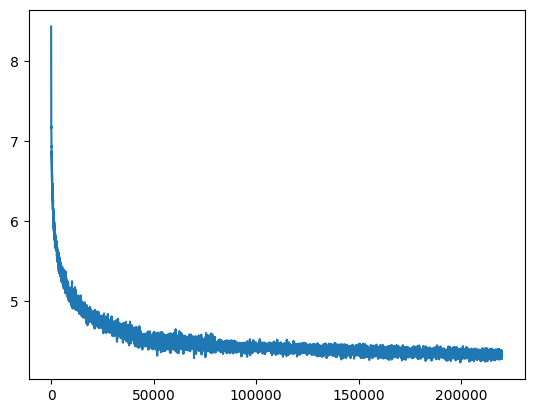

100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 37.35it/s]


{'train': tensor(4.3571), 'dev': tensor(4.3358)}

In [169]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

batch_size = 32
n_steps = 140000
avg_window = 64

batch_iterator = get_batch_iterator('train', batch_size, context_length)

pbar = tqdm(range(n_steps))
for steps in pbar:
    xb, yb = next(batch_iterator)
    logits, loss = model(xb, yb)
    losses.append(loss.item())
    pbar.set_description(f"Train loss: {np.mean(losses[-avg_window:]):.4f}")
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(moving_average(losses, avg_window))
plt.show()
estimate_loss(200)

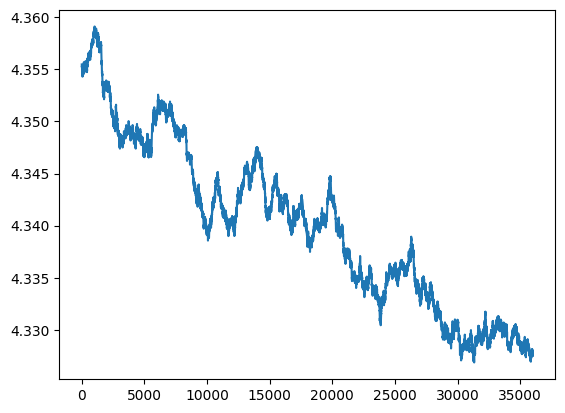

In [172]:
plt.plot(moving_average(losses[-40000:], 4000))
plt.show()

In [127]:
for g in optimizer.param_groups:
    g['lr'] = 1e-4

In [178]:
train_loss, dev_loss = estimate_loss(1000).values()
train_loss, dev_loss

100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.07it/s]


(tensor(4.3340), tensor(4.3372))

In [13]:
model_path = f"models/transformer_pile_128_0_4.3340.pt"

In [180]:
os.makedirs('models', exist_ok=True)

if not os.path.exists(model_path):
    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'losses': losses,
                'train_loss': train_loss,
                'dev_loss': dev_loss,
                'steps': len(losses),
                }, model_path)

In [19]:
checkpoint = torch.load(model_path)
model = Transformer().to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [20]:
checkpoint['steps']

220000

In [21]:
idx = torch.tensor(enc.encode('\n'), dtype=torch.long)[None, :].to(device)
# torch.manual_seed(1)
with torch.no_grad():
    print(enc.decode(model.generate(idx, 128)[0].tolist()))



½ cuprical pen !us add Epato" come along the brown candatini"

A sip of ratching glass.product_captince, "What time goes on with dried, sour, slightly with a recipe, moist!

1½rait bis strftimees. There's recognized solutions. Spoon the Spread off the star of an exciting and lake half months, and the strength of this road—the quickly touching shore; or when the air cost of ship with a cabinet that Yuri all phided towards the tender lodge._

Take a skirt

I load always very exciting, and I quas


In [22]:
class SparseAutoencoder(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.encoder = nn.Linear(n_embed * 4, n_features)
        self.decoder = nn.Linear(n_features, n_embed * 4)
        # self.decoder_bias = nn.Parameter(torch.zeros(n_embed * 4))  # explicitly define decoder bias so we can subtract it from the input
        self.relu = nn.ReLU()

    def forward(self, x_in, compute_loss=False, compute_ap=False):
        f = self.encode(x_in)
        x = self.decoder(f)
        if compute_loss:
            recon_loss = F.mse_loss(x, x_in)
            reg_loss = f.abs().sum(dim=-1).mean()
            loss = recon_loss + reg_loss
        else:
            recon_loss = None
            reg_loss = None
        if compute_ap:
            ap = (f > 0).sum(dim=-1).mean()
            return x, recon_loss, reg_loss, ap  # a little messy
        return x, recon_loss, reg_loss

    def encode(self, x_in):
        x = x_in - self.decoder.bias
        f = self.relu(self.encoder(x))
        return f

    def normalize_decoder_weights(self):
        with torch.no_grad():
            self.decoder.weight.data = nn.functional.normalize(self.decoder.weight.data, p=2, dim=1)

In [183]:
# batch_size = 256

# num_batches = len(train_data)

# def iterate_data(split, batch_size=batch_size):
#     data = train_data if split == 'train' else dev_data
#     rows = data[:len(data) - len(data) % (context_length*batch_size)].view(-1, batch_size, context_length)
#     print(f"batches: {rows.shape[0]}")
#     for batch in rows:
#         yield batch

# batch_iterator = iterate_data('train')

In [184]:
# import h5py

# hdf5_path = 'data/embeddings_0.hdf5'

# with h5py.File(hdf5_path, 'w') as hdf5_file:
#     with torch.no_grad():
#         maxshape = (None, n_embed*4)
#         dataset = hdf5_file.create_dataset('tensors', (0, n_embed*4), maxshape=maxshape, dtype='float32')
        
#         for batch in tqdm(batch_iterator):
#             embedding = model.forward_embedding(batch.to(device))
#             flattened_embedding = embedding.view(-1, n_embed*4)
    
#             # Append the flattened tensor to the HDF5 dataset
#             dataset.resize((dataset.shape[0] + flattened_embedding.shape[0]), axis=0)
#             dataset[-flattened_embedding.shape[0]:] = flattened_embedding.cpu().numpy()


In [185]:
# import numpy as np

# batch_size = 128

# def iterate_embeddings(batch_size):
#     with h5py.File(hdf5_path, 'r') as hdf5_file:
#         while True:
#             dataset = hdf5_file['tensors']
#             dataset_size = dataset.shape[0]
#             random_indices = torch.randint(dataset_size, size=(batch_size,))
#             random_samples = torch.tensor(np.array([dataset[idx] for idx in random_indices]))
#             yield random_samples

# embedding_iterator = iterate_embeddings(batch_size)

In [86]:
# next(embedding_iterator).shape

torch.Size([128, 512])

In [23]:
autoencoder = SparseAutoencoder(4096).to(device)
count_params(autoencoder)
autoencoder

4198912


SparseAutoencoder(
  (encoder): Linear(in_features=512, out_features=4096, bias=True)
  (decoder): Linear(in_features=4096, out_features=512, bias=True)
  (relu): ReLU()
)

In [24]:
def get_embedding_iterator(split, batch_size, context_length=context_length):
    batch_iterator = get_batch_iterator(split, batch_size, context_length)
    while True:
        xb, _ = next(batch_iterator)
        with torch.no_grad():
            x_embedding, _ = model.forward_embedding(xb)
        random_idxs = torch.randint(context_length, (batch_size,))
        filtered_xe = x_embedding[range(batch_size), random_idxs, :]  # only take one sample per batch element to avoid local similarities
        yield filtered_xe

In [25]:
train_steps = 100000
lambda_reg = 0.002
batch_size = 512
lr = 1e-6

autoencoder = SparseAutoencoder(4096).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
losses = []
recon_losses = []
reg_losses = []

In [303]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Recon: 0.082 Reg: 0.051: 100%|████████| 100000/100000 [1:33:37<00:00, 17.80it/s]


Loss:	0.134
Recon:	0.083
Reg:	0.051


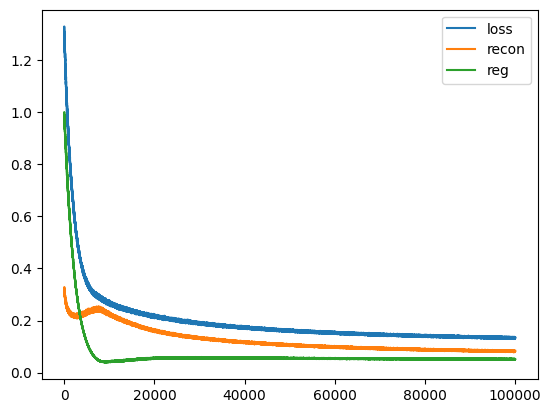

In [26]:
import matplotlib.pyplot as plt
import h5py

# train_steps = 40000
# batch_size = 512
losses = []
recon_losses = []
reg_losses = []
batch_iterator = get_batch_iterator('train', batch_size, context_length)

pbar = tqdm(range(train_steps))

for _ in pbar:
    xb, _ = next(batch_iterator)
    with torch.no_grad():
        x_embedding, _ = model.forward_embedding(xb)
    random_idxs = torch.randint(context_length, (batch_size,))
    filtered_xe = x_embedding[range(batch_size), random_idxs, :]  # only take one sample per batch element to avoid local similarities

    # x_embedding = next(embedding_iterator).to(device)
    optimizer.zero_grad()
    outputs, recon_loss, reg_loss = autoencoder(filtered_xe, compute_loss=True)
    reg_loss = lambda_reg * reg_loss
    loss = recon_loss + reg_loss
    loss.backward()
    optimizer.step()
    autoencoder.normalize_decoder_weights()
    
    losses.append(loss.item())
    recon_losses.append(recon_loss.item())
    reg_losses.append(reg_loss.item())

    pbar.set_description(f"Recon: {np.mean(recon_losses[-100:]):.3f} Reg: {np.mean(reg_losses[-100:]):.3f}")

print(f"Loss:\t{loss:.3f}\nRecon:\t{recon_loss:.3f}\nReg:\t{reg_loss:.3f}")
plt.plot(losses, label='loss')
plt.plot(recon_losses, label='recon')
plt.plot(reg_losses, label='reg')
plt.legend()
plt.show()

In [27]:
path = "models/autoencoder_pile_0.002_1e-6.pt"

os.makedirs('models', exist_ok=True)

if not os.path.exists(path):
    torch.save({
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'losses': losses,
                'steps': len(losses),
                }, path)

In [28]:
print(lambda_reg)

0.002


In [321]:
train_steps = 100000
lambda_reg = 0.0015
batch_size = 512
lr = 1e-5

autoencoder = SparseAutoencoder(4096).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
losses = []
recon_losses = []
reg_losses = []

Recon: 0.049 Reg: 0.032: 100%|████████| 100000/100000 [2:31:57<00:00, 10.97it/s]


Loss:	0.081
Recon:	0.050
Reg:	0.031


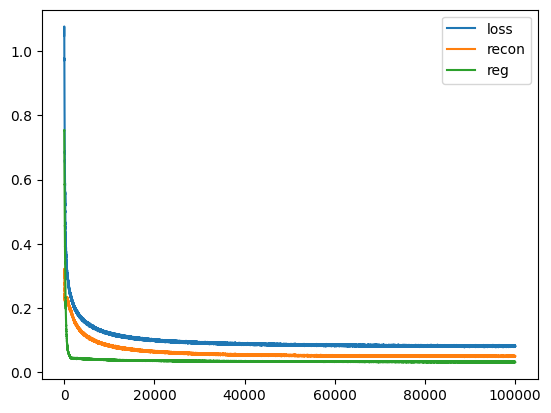

In [322]:
import matplotlib.pyplot as plt
import h5py

# train_steps = 40000
# batch_size = 512
losses = []
recon_losses = []
reg_losses = []
activation_proportions = []
batch_iterator = get_batch_iterator('train', batch_size, context_length)

pbar = tqdm(range(train_steps))

for _ in pbar:
    xb, _ = next(batch_iterator)
    with torch.no_grad():
        x_embedding, _ = model.forward_embedding(xb)
    random_idxs = torch.randint(context_length, (batch_size,))
    filtered_xe = x_embedding[range(batch_size), random_idxs, :]  # only take one sample per batch element to avoid local similarities

    # x_embedding = next(embedding_iterator).to(device)
    optimizer.zero_grad()
    outputs, recon_loss, reg_loss = autoencoder(filtered_xe, compute_loss=True, compute_ap=True)
    reg_loss = lambda_reg * reg_loss
    loss = recon_loss + reg_loss
    loss.backward()
    optimizer.step()
    autoencoder.normalize_decoder_weights()
    
    losses.append(loss.item())
    recon_losses.append(recon_loss.item())
    reg_losses.append(reg_loss.item())

    pbar.set_description(f"Recon: {np.mean(recon_losses[-100:]):.3f} Reg: {np.mean(reg_losses[-100:]):.3f}")

print(f"Loss:\t{loss:.3f}\nRecon:\t{recon_loss:.3f}\nReg:\t{reg_loss:.3f}")
plt.plot(losses, label='loss')
plt.plot(recon_losses, label='recon')
plt.plot(reg_losses, label='reg')
plt.legend()
plt.show()

Loss:	0.002
Recon:	0.002
Reg:	0.000


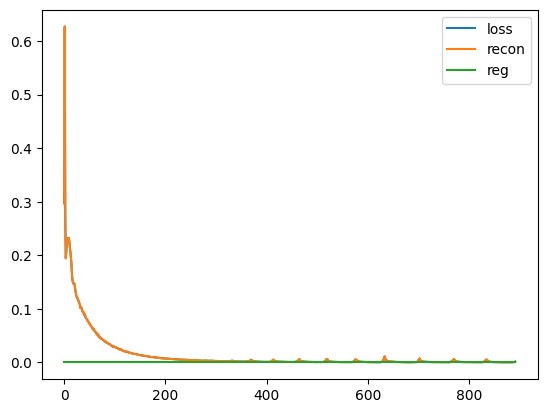

In [308]:
print(f"Loss:\t{loss:.3f}\nRecon:\t{recon_loss:.3f}\nReg:\t{reg_loss:.3f}")
plt.plot(losses[:], label='loss')
plt.plot(recon_losses[:], label='recon')
plt.plot(reg_losses[:], label='reg')
plt.legend()
plt.show()

In [16]:
path = "models/autoencoder_pile_0.0015.pt"

checkpoint = torch.load(path)
autoencoder.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [32]:
identity = lambda x: (x, None, None)
idx = torch.tensor(enc.encode('\n'), dtype=torch.long)[None, :].to(device)
# torch.manual_seed(1)
with torch.no_grad():
    print(enc.decode(model.generate_ablation(idx, 128, autoencoder)[0].tolist()))


 *
 *Joc
 *_tri_er,
 *_* *_, size will be listed to
 *xx_*_release_conf_ms_read_res_trigger_x_annels_buff_step_ep_PC_mult_size_comp = *nt_rc_common_map_start_cmd_queue_son_shared_r_cur_r_array_info_offset_m_->kernel_cp_address_int_A_bytes_f_std_align_space_dan_bytes(xf  */
      


100%|█████████████████████████████████████████| 320/320 [00:22<00:00, 14.38it/s]


0.920654296875


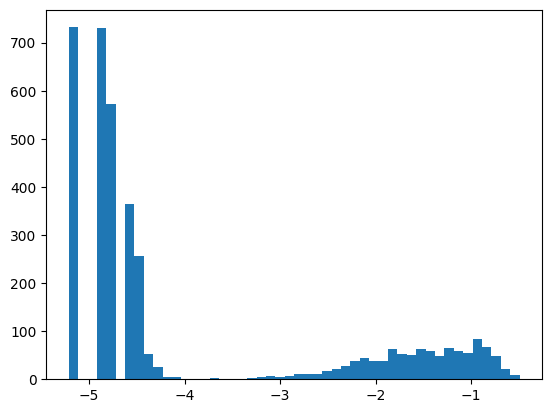

In [33]:
import matplotlib.pyplot as plt

batch_size = 512
embedding_iterator = get_embedding_iterator('train', batch_size)

def feature_density_histogram(num_samples=16384):
    all_outputs = []
    for i in tqdm(range(num_samples // batch_size)):
        batch = next(embedding_iterator).to(device)
        outputs = autoencoder.encode(batch)  # (128, 4096)
        all_outputs.append(outputs)
    all_outputs = torch.concat(all_outputs)
    return all_outputs

with torch.no_grad():
    activation_densities = feature_density_histogram(16384*10)
B, C = activation_densities.shape
activation_densities = (activation_densities > 0).to(torch.float32).mean(dim=0)
activation_densities = activation_densities[activation_densities > 0]
activation_densities = activation_densities.log10().cpu().tolist()
print(len(activation_densities)/C)
plt.hist(activation_densities, bins=48)
plt.show()

# We want nearly all features to be below 1% density: "The number of features with density above 1%. A significant number of features above this level seems to correspond to an L1 coefficient that is too low."

In [279]:
(activation_densities > -1).sum()

tensor(42, device='mps:0')

In [35]:
print(f"{(((activation_densities > 0).to(torch.float32).mean(dim=0) > 0).sum().item() / 4096 * 100):.2f}%")

TypeError: '>' not supported between instances of 'list' and 'int'

In [36]:
batch_size = 4096
embedding_iterator = get_embedding_iterator('train', batch_size)
x_embedding = next(embedding_iterator).to(device)

activation_counts = (autoencoder.encode(x_embedding) > 1e-3 * 1.0).sum(dim=-1).to(torch.float32)
print(f"Median:\t{activation_counts.median().item()}\nMean:\t{activation_counts.mean().item():.2f}\nStd:\t{activation_counts.std().item():.2f}")
# median number of hot features per token for each element in the batch, want to be "less than 10 or 20" as per paper

# "we generally target a L^0 norm that is less than 10 or 20. We especially distrust solutions where the L^0 norm is a significant fraction of the transformer’s activation dimensionality.

Median:	60.0
Mean:	59.76
Std:	15.07


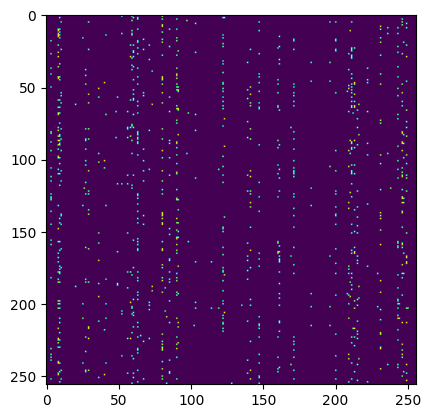

In [37]:
with torch.no_grad():
    out = autoencoder.encode(x_embedding) > 1e-3
B, C = out.shape
plt.imshow(out.cpu()[:256, 2400:2400+256])

In [1152]:
# print(autoencoder(x))
for vec in x_embedding:
    hot = ((autoencoder.encode(vec) > 1e-4) * 1).sum(dim=1)
    print(hot.sum())

tensor(679, device='mps:0')
tensor(685, device='mps:0')
tensor(619, device='mps:0')
tensor(551, device='mps:0')
tensor(606, device='mps:0')
tensor(631, device='mps:0')
tensor(496, device='mps:0')
tensor(634, device='mps:0')
tensor(540, device='mps:0')
tensor(517, device='mps:0')
tensor(495, device='mps:0')
tensor(579, device='mps:0')
tensor(587, device='mps:0')
tensor(579, device='mps:0')
tensor(580, device='mps:0')
tensor(730, device='mps:0')
tensor(677, device='mps:0')
tensor(537, device='mps:0')
tensor(599, device='mps:0')
tensor(476, device='mps:0')
tensor(774, device='mps:0')
tensor(541, device='mps:0')
tensor(527, device='mps:0')
tensor(482, device='mps:0')
tensor(531, device='mps:0')
tensor(457, device='mps:0')
tensor(566, device='mps:0')
tensor(508, device='mps:0')
tensor(500, device='mps:0')
tensor(483, device='mps:0')
tensor(519, device='mps:0')
tensor(537, device='mps:0')
tensor(531, device='mps:0')
tensor(545, device='mps:0')
tensor(446, device='mps:0')
tensor(548, device='

In [476]:
!git a && git c 'add function to forward pass transformer using autoencoder for MLP activations'

[main 81e9b8e] add function to forward pass transformer using autoencoder for MLP activations
 1 file changed, 240 insertions(+), 204 deletions(-)


In [39]:
batch_iterator = get_batch_iterator('train', 32, 128)
xb, yb = next(batch_iterator)
print(xb.shape)

with torch.no_grad():
    t_logits, t_loss = model(xb, yb)
    a_logits, a_loss = model.forward_ablation(xb, autoencoder, yb)

print(t_loss, a_loss)

torch.Size([32, 128])
tensor(4.2539, device='mps:0') tensor(5.0997, device='mps:0')


In [41]:
def get_features(x):
    embedding, _ = model.forward_embedding(x)
    features = autoencoder.encode(embedding)
    return features

features = get_features(xb)

print(features.shape, xb.shape)

torch.Size([16, 128, 4096]) torch.Size([16, 128])


In [42]:
feature_dict = {i: [0, []] for i in range(4096)}
context_list = []

threashold = 1e-5

num_iters = 32000
batch_size = 16
samples_per_row = 4

batch_iterator = get_batch_iterator('train', batch_size, 128)

for _ in tqdm(range(num_iters)):
    xb, _ = next(batch_iterator)
    features = get_features(xb)
    features = features.cpu()
    # print(features)
    for i, row in enumerate(xb):  # iterate thru rows in a batch
        # for j in range(row.shape[0]):  # iterate thru tokens in a row
        for j in np.random.choice(row.shape[0], samples_per_row, replace=False):  #torch.randint(row.shape[0], (samples_per_row,), replact=False):
            token = row[j]
            context = row[max(j-4, 0):j+5]
            context_list.append((token.item(), context.tolist()))
            context_idx = len(context_list) - 1
            
            feature_vec = features[i, j]
            # print(feature_vec.shape)
            activation_idxs = (feature_vec > threashold).nonzero()
            # print(activation_idxs.shape)
            # print(activation_idxs)

            for a_idx in activation_idxs:
                a_idx = a_idx[0].item()
                feature_dict[a_idx][0] += 1
                if feature_dict[a_idx][0] < 512:
                    feature_dict[a_idx][1].append((context_idx, feature_vec[a_idx].item()))



100%|█████████████████████████████████████| 32000/32000 [14:43<00:00, 36.22it/s]


In [43]:
counts = [v[0] for v in feature_dict.values()]
max(counts)

657521

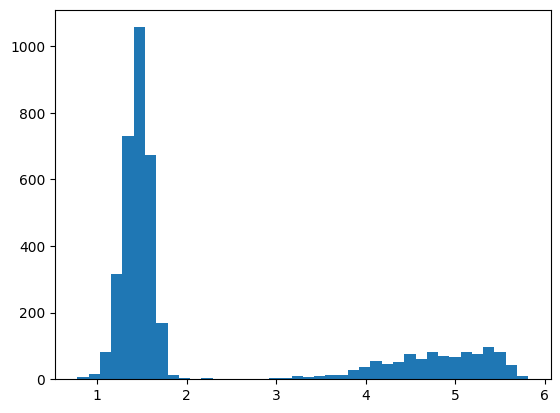

In [46]:
plt.hist([math.log10(ctx[0]) for ctx in feature_dict.values() if ctx[0]], bins=40)
plt.show()

In [54]:
sorted_dict = sorted(feature_dict.items(), key = lambda x: x[1][0] if x[1][0] >= 4 else 0, reverse=True)

In [55]:
a = 0


# for feat_idx, info in feature_dict.items():
for feat_idx, info in sorted_dict[:100]:
    a += 1
    if a >= 10000:
        break
    count = info[0]
    ctxs = sorted(info[1], key=lambda x: x[1], reverse=True)
    ctxs = [ctx for ctx in ctxs if ctx[1] > 0.5]
    # ctxs = info[1]
    print(f"Feature idx:\t{feat_idx}\nCount:\t\t{count}")
    for context_idx, feature_activation in ctxs[:10]:
        token_idx = context_list[context_idx][0]
        token = enc.decode([token_idx])
        context = enc.decode(context_list[context_idx][1])
        print(f'  Token: {repr(token)}\n  Token Index: {token_idx}\n  Context: {repr(context)}\n  Activation: {feature_activation:.3f}')
        print()

Feature idx:	3472
Count:		657521
  Token: ' Compared'
  Token Index: 27492
  Context: '2019indexnet]. Compared with the baseline,'
  Activation: 1.362

  Token: 'aviour'
  Token Index: 37716
  Context: '\n###### Behavioural intention to van'
  Activation: 1.106

  Token: ' accordance'
  Token Index: 10213
  Context: ' was carried out in accordance with the recommendations of'
  Activation: 1.072

  Token: ' introduced'
  Token Index: 5495
  Context: '. 24, as introduced, also proposed to'
  Activation: 1.036

  Token: ' printed'
  Token Index: 10398
  Context: '.\n\nUse printed money to fund the'
  Activation: 0.986

  Token: 'In'
  Token Index: 818
  Context: ' well.\n\nIn May, 1716'
  Activation: 0.925

  Token: ' year'
  Token Index: 614
  Context: ' outlay. The year after, it was'
  Activation: 0.859

  Token: ' Bureau'
  Token Index: 9840
  Context: ' to the US Census Bureau, Tashch'
  Activation: 0.841

  Token: ' '
  Token Index: 220
  Context: '         '
  Activation: 0.841

 

In [114]:
math.log10(0)

ValueError: math domain error

In [215]:
!git a && git commit -m "beginnings of feature exploration"

[main 4a9d3c5] beginnings of feature exploration
 1 file changed, 5317 insertions(+), 113 deletions(-)


python3.10(56245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [5]:
import zstandard as zstd
import json

# Path to your .jsonl.zst file
file_path = '/Volumes/External/EleutherAI_ThePile_v1/pile/val.jsonl.zst'

# Open the compressed file
with open(file_path, 'rb') as compressed:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(compressed) as reader:
        while True:
            chunk = reader.read(65536)  # Read a chunk of data
            if not chunk:
                break
            # Process chunk (which is a part of your decompressed data)
            for line in chunk.splitlines():
                json_data = json.loads(line.decode('utf-8'))
                break
            break
                # Process your json_data here

{'pile_set_name': 'OpenWebText2'}


In [181]:
!git a && git c "scripts for using the pile"


[main f8ebab5] scripts for using the pile
 1 file changed, 404 insertions(+), 4868 deletions(-)
